# Analiza i Klasyfikacja Wiadomości na Prawdziwe i Fałszywe

## Cel Projektu
Projekt ma na celu opracowanie modelu, który będzie w stanie odróżnić fałszywe wiadomości od prawdziwych. W tym celu, wykorzystamy techniki przetwarzania języka naturalnego (NLP) i klasyfikacji.

### Importujemy niezbędne biblioteki

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

## Zbiór Danych
Zbiór danych zawiera wiadomości sklasyfikowane jako 'prawdziwe' oraz 'fałszywe'.

In [102]:
true = pd.read_csv("Fake.csv")
fake = pd.read_csv("True.csv")

## Przegląd Danych
Przykładowe dane z obu kategorii:

**Prawdziwe wiadomości** 


In [103]:
true.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


**Fałszywe wiadomości**

In [104]:
fake.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Przetwarzanie Danych
Dane z obu kategorii zostały połączone w jeden zbiór, z odpowiednimi etykietami dla każdej kategorii.

In [105]:
true['category'] = 1
fake['category'] = 0

In [106]:
all = pd.concat([true,fake])

## Wizualizacje Danych

### Rozkład Kategorii Wiadomości

Pierwszy wykres pokazuje rozkład wiadomości prawdziwych i fałszywych w naszym zbiorze danych. Kolorem niebieskim oznaczone są wiadomości prawdziwe (1), a kolorem pomarańczowym – fałszywe (0). Ten wykres jest potrzebny do zrozumienia proporcji danych, które model będzie analizować.

<Axes: xlabel='category', ylabel='count'>

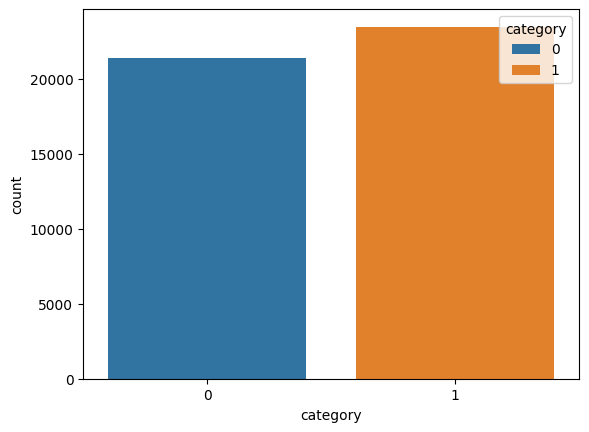

In [107]:
sns.countplot(x="category", data=all, hue = "category")

### Rozkład Tematów Wiadomości

Drugi wykres ilustruje, jak tematy wiadomości są rozłożone między różnymi kategoriami. Pozwala to zobaczyć, które tematy są częściej powiązane z fałszywymi lub prawdziwymi wiadomościami. Na przykład, możemy analizować, czy pewne tematy są bardziej podatne na fałszywe informacje.

<Axes: xlabel='subject', ylabel='count'>

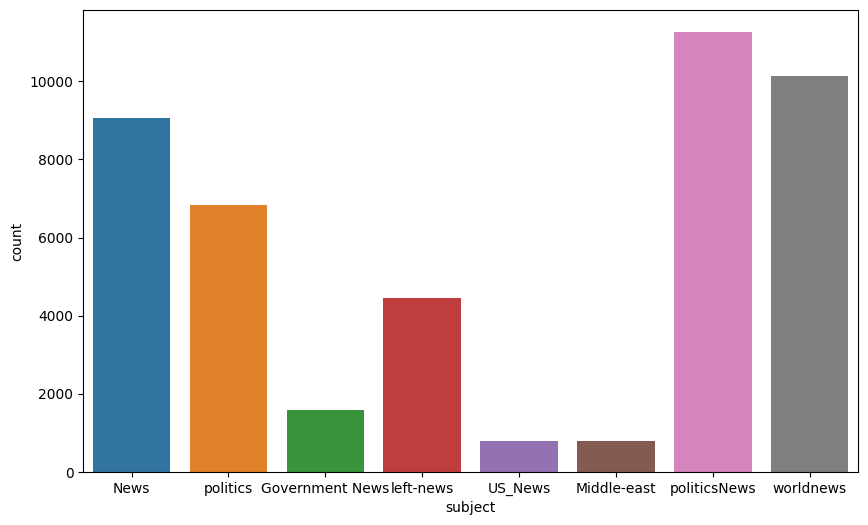

In [108]:
plt.figure(figsize=(10,6))
sns.countplot(x="subject", data=all, hue = "subject")

### Sprawdzenie Brakujących Danych

Pierwszym krokiem było sprawdzenie, czy w danych występują brakujące wartości, co mogłoby wpłynąć na jakość modelowania.

In [109]:
all.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

### Redukcja Wymiarów

Aby ułatwić modelowanie i poprawić wydajność algorytmów, zdecydowaliśmy się usunąć mniej istotne kolumny, takie jak `subject`, `date` i `title`. Pozwoliło to skupić analizę wyłącznie na treści wiadomości i ich kategoriach.

In [110]:
df = all.drop(["subject","date","title"],axis = 1)
df.head()

,text,category
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


### Resetowanie Indeksów

Po przefiltrowaniu kolumn, zresetowano indeksy dataframe'u, aby zapewnić ciągłość i poprawność indeksowania.

In [111]:
df = df.reset_index()
df = df.drop("index", axis = 1)

Na koniec, otrzymujemy uporządkowany DataFrame, który zawiera tylko te kolumny, które będą użyte do budowy modelu klasyfikacji. Oto jak prezentują się nasze dane po obróbce.

In [112]:
df

,text,category
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",0
44895,MINSK (Reuters) - In the shadow of disused Sov...,0
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [ ]:
nltk.download('wordnet') #umożliwia sprowadzenie ich do formy podstawowej
nltk.download("stopwords") #instruuje NLTK do pobrania listy stopwords dla języka angielskiego
stopwords = stopwords.words("english") #przypisuje do zmiennej `stopwords` listę angielskich słów funkcyjnych pobranych w poprzednim kroku
lemma=WordNetLemmatizer() #lematyzator jest używany do przekształcania słów do ich bazowej formy leksykalnej ('am','are', 'is' -> 'be')

: 

# Czyszczenie Tekstu

Aby tekst był lepiej przetwarzany przez algorytmy uczenia maszynowego, konieczne było jego uprzednie oczyszczenie i normalizacja.

### **Proces Czyszczenia Tekstu**

1. **Konwersja na Małe Litery**: Wszystkie teksty zostały przekonwertowane na małe litery, aby uniknąć różnicowania słów ze względu na wielkość liter.

2. **Usunięcie Znaków Specjalnych**: Następnie usunięto znaki specjalne, w tym znaki interpunkcyjne oraz cyfry, aby skupić się wyłącznie na słowach.

3. **Usunięcie Słów Funkcyjnych (Stop Words)**: Usunięto również tzw. słowa funkcyjne, które nie niosą większej wartości.

4. **Lematyzacja**: Ostatecznie zastosowano lematyzację, czyli sprowadzenie słów do ich podstawowej formy, co pomaga w ujednoliceniu odmian słów.

In [114]:
def cleaning(x):
    cleaned = ""
    x=x.lower()
    x=re.sub(r"[-()\"#!@$%^&*{}?.,:]"," ",x)
    x=re.sub(r"\s+"," ",x)
    x=re.sub('[^A-Za-z0-9]+',' ', x)
    for word in x.split():
        if word not in stopwords:
            cleaned+=lemma.lemmatize(word)+" "
    return cleaned

In [115]:
df["text"] = df["text"].apply(cleaning)

Po przetworzeniu, teksty wyglądają następująco:

In [116]:
df.head()

,text,category
0,donald trump wish american happy new year leav...,1
1,house intelligence committee chairman devin nu...,1
2,friday revealed former milwaukee sheriff david...,1
3,christmas day donald trump announced would bac...,1
4,pope francis used annual christmas day message...,1


## Wizualizacja Danych za pomocą Chmur Słów

Chmury słów (Word Clouds) są efektownym sposobem wizualizacji najczęściej występujących słów w zbiorze tekstów. Wykorzystujemy je do zilustrowania różnic w użyciu słów między wiadomościami uznawanymi za prawdziwe i tymi uznawanymi za fałszywe.

### Generowanie Chmur Słów

Dla każdej kategorii wiadomości (prawdziwe i fałszywe) generujemy oddzielną chmurę słów, które pokazują 100 najczęściej występujących słów w tych kategoriach. Wykorzystanie chmur słów pozwala na szybką i intuicyjną ocenę charakteru tekstów oraz pomaga zidentyfikować słowa kluczowe, które mogą być szczególnie charakterystyczne dla fałszywych lub prawdziwych informacji.

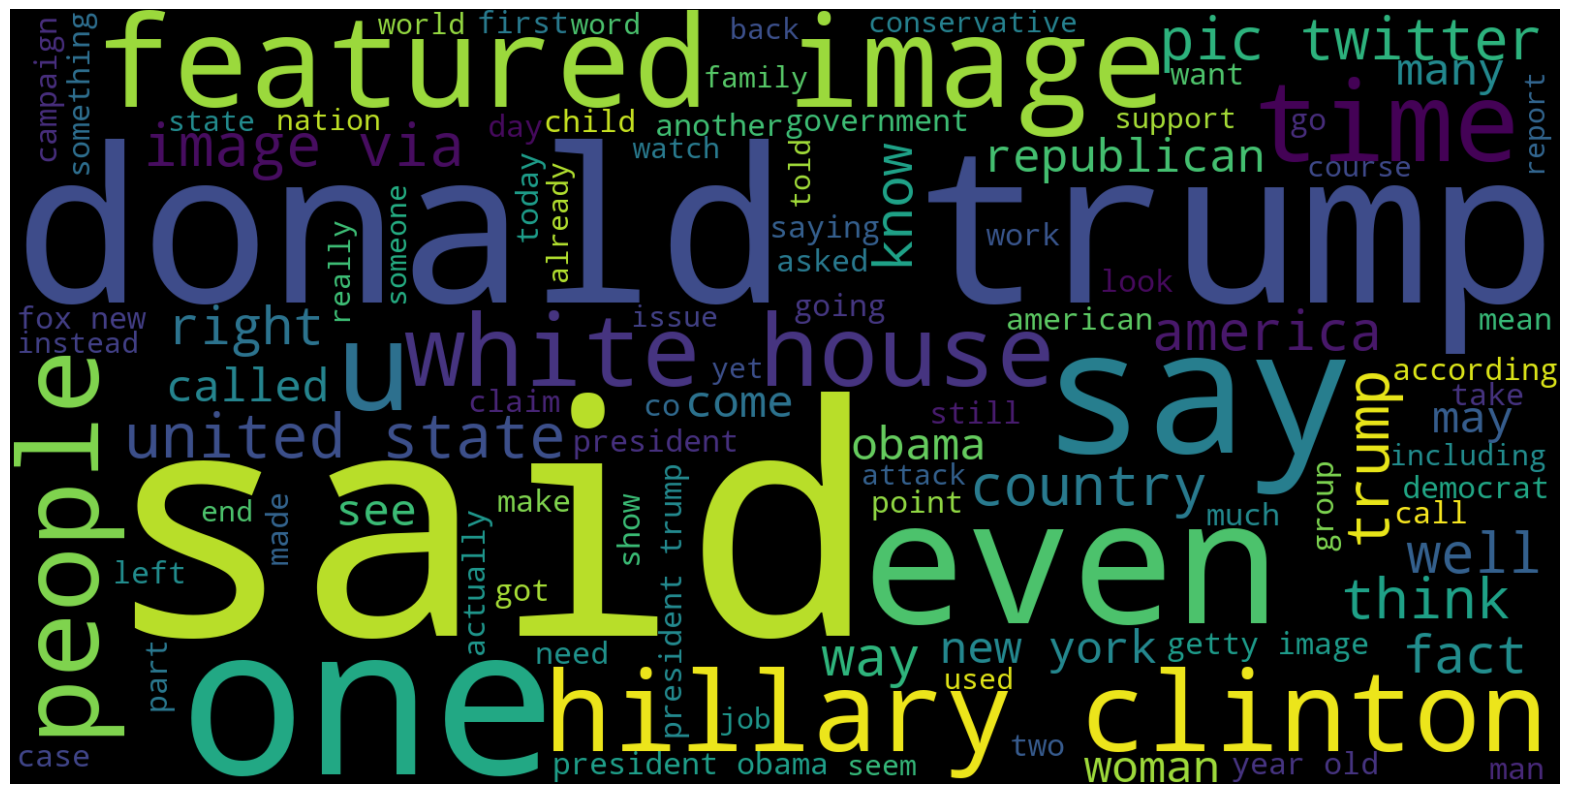

In [117]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(df[df.category == 1].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')

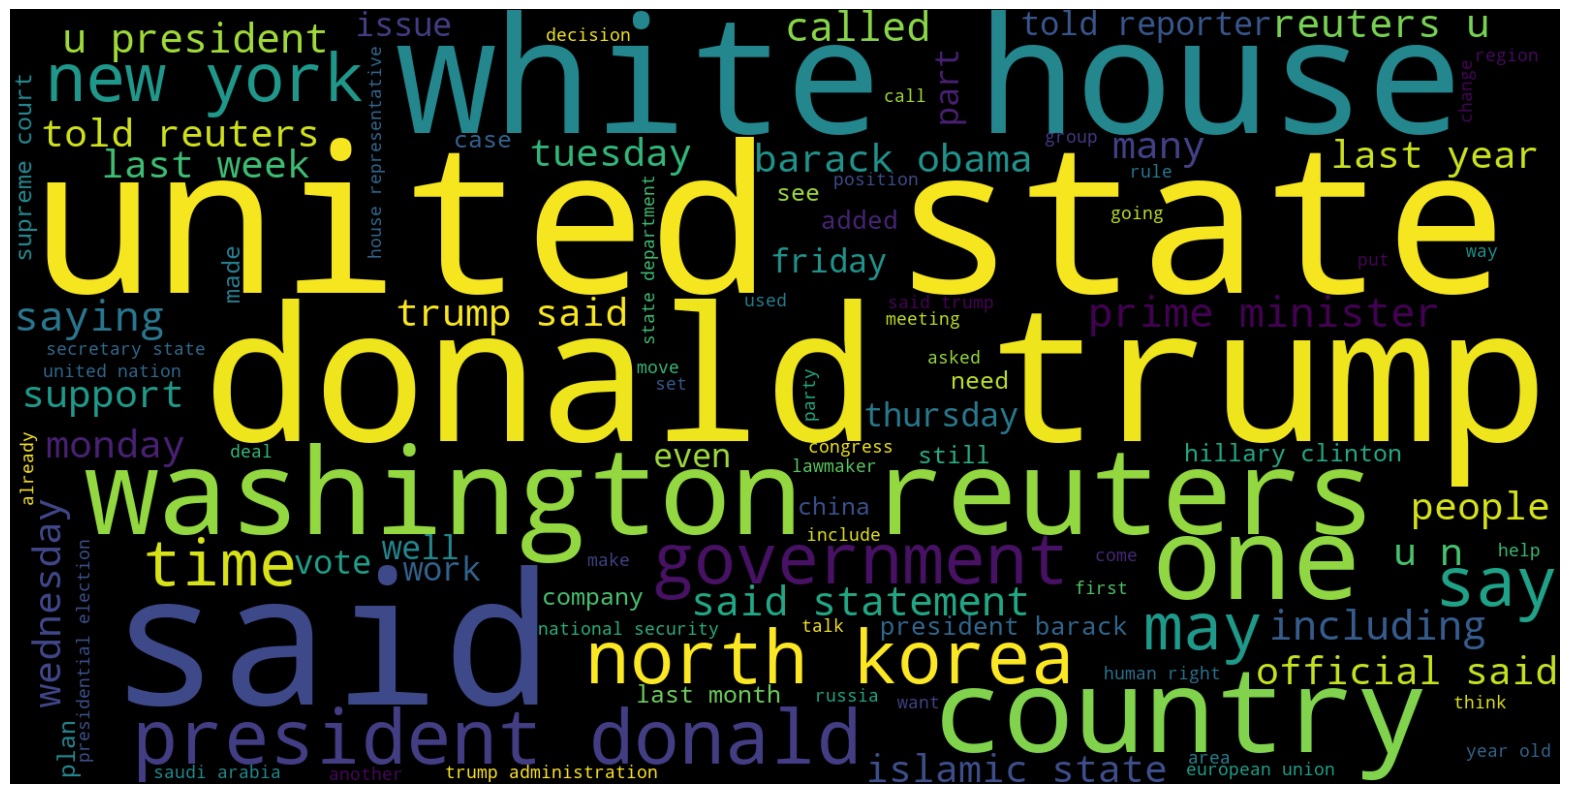

In [118]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(df[df.category == 0].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')

## Modelowanie i Walidacja

Aby zbudować skuteczny model klasyfikacji wiadomości jako prawdziwych lub fałszywych, przeprowadziliśmy szereg kroków, które obejmowały przygotowanie danych, ich podział, a następnie trening modelu klasyfikacyjnego.

### Podział Danych

Dane zostały podzielone na zbiory uczące i testowe w stosunku 67% do 33%. Taki podział pozwala na trenowanie modelu na większym zbiorze danych, jednocześnie zachowując wystarczająco duży zbiór testowy do walidacji modelu.

In [119]:
from sklearn.model_selection import train_test_split

feature =df["text"]
target=df["category"]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.33, random_state=42)

Importujemy moduły z biblioteki scikit-learnktóre są wykorzystywane do budowy modelu klasyfikacji tekstu.

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Budowa Potoku Przetwarzania

Używając biblioteki `scikit-learn`, zbudowaliśmy potok przetwarzania, który obejmuje:
- TF-IDF wektoryzację cech tekstowych, co pozwala na przekształcenie tekstu na format numeryczny.
- Klasyfikator lasu losowego, znany z dobrej wydajności w zadaniach klasyfikacyjnych na zróżnicowanych zestawach danych.


In [121]:
text_clf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))])

### Dobór Parametrów Modelu

Wykorzystując `GridSearchCV`, przeprowadziliśmy przeszukiwanie siatkowe parametrów modelu, takich jak liczba estymatorów i maksymalna głębokość drzew w celu znalezienia najlepszej konfiguracji dla klasyfikatora lasu losowego.

In [122]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [1, 2],
}

In [123]:
grid_search = GridSearchCV(text_clf, param_grid, cv=5, n_jobs=-1, verbose=2)

In [124]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [100, 200, 300]},
             verbose=2)

In [125]:
print("Najlepsze parametry: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

Najlepsze parametry:  {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}


### Wyniki i Walidacja Modelu

In [126]:
predictions = best_model.predict(X_test)

In [127]:
from sklearn import metrics
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7039
           1       0.99      0.99      0.99      7778

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



In [128]:
print(metrics.accuracy_score(y_test,predictions))

0.9925086049807653


Model osiągnął precyzję, czułość i wynik F1 na poziomie 0.99, co świadczy o jego wysokiej dokładności w identyfikacji wiadomości jako prawdziwych lub fałszywych. Wartości 'support' dla fałszywych i prawdziwych wiadomości wynoszą odpowiednio 7039 i 7778, co pokazuje równomierny rozkład próbek testowych.

### Macierz Pomyłek

Macierz pomyłek została wygenerowana, aby zilustrować wyniki klasyfikacji modelu, wskazując na liczby prawdziwie pozytywnych, fałszywie pozytywnych, prawdziwie negatywnych i fałszywie negatywnych klasyfikacji.

<Axes: >

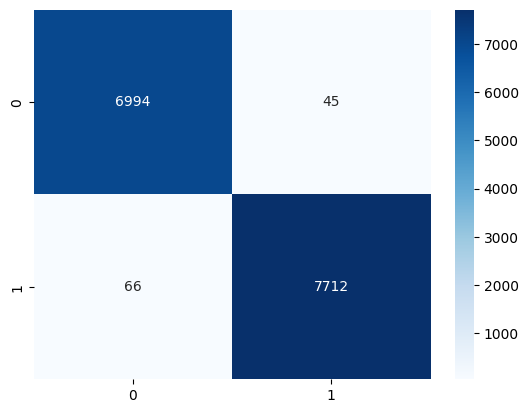

In [129]:
cm = metrics.confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot = True,fmt = "d",cmap = "Blues")

## Podsumowanie

Projekt ten demonstruje mocne zdolności modelowania danych tekstowych do rozpoznawania i różnicowania między autentycznymi a manipulowanymi wiadomościami, co jest istotne w dzisiejszym środowisku medialnym pełnym dezinformacji. Zastosowanie zaawansowanych technik przetwarzania języka naturalnego oraz metod klasyfikacyjnych, takich jak lasy losowe w połączeniu z analizą TF-IDF, pozwoliło na osiągnięcie wysokiej dokładności oraz solidnej wiarygodności w rozróżnianiu treści autentycznych od fałszywych.